In [294]:
import psycopg2
import glob
import re
from string import Template
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.cluster.hierarchy as shc 
from scipy.spatial.distance import squareform, pdist
from collections import defaultdict
from itertools import combinations

In [295]:
dc_file_dir ='/home/opc/chenjie/labelling_explanation/experiments/dc/'
flist = ['subset_dc_sample_10',  'subset_dc_sample_20', 'subset_dc_sample_50','subset_dc_sample_30','subset_dc_sample_100']
conn=psycopg2.connect('dbname=holo user=holocleanuser')
cur=conn.cursor()

In [296]:
dc_violation_template=Template("SELECT t1._tid_ FROM $table t1 WHERE EXISTS (SELECT t2.* FROM $table AS t2 WHERE ($dc_desc)) ")
ops = re.compile(r'IQ|EQ')  

In [297]:
def parse_rule_to_where_clause(rule):
    # support EQ and IQ only so far
    res = []
    for xl in rule.split('&'):
        if(ops.search(xl)):
            if(ops.search(xl).group()=='EQ'):
                sign='='
            else:
                sign='!='
            bracket_content = re.findall(r'\((.*)\)', xl)[0]
            res.append(sign.join(re.sub(r'(t[1|2]\.)([-\w]+)', r'\1"\2"', bracket_content).split(',')))
    return ' AND '.join(res)

In [298]:
def cluster_and_plot(filename):
    with open(filename, 'r') as file:
        rules = file.read().split('\n')
    rules = [r for r in rules if r!='']
    violation_dict = {r:None for r in rules}
    for r in rules:
        r_q  = dc_violation_template.substitute(table='adult500', dc_desc=parse_rule_to_where_clause(r))
        cur.execute(r_q)
        violation_dict[r]=[t[0] for t in cur.fetchall()]
    vector_dict = {r:None for r in rules}
    for r in rules:
        vector_dict[r] = [1 if i in violation_dict[r] else 0  for i in range(0, 500)]

    vector_list = []

    for k in vector_dict:
        l = [k]
        l.extend(vector_dict[k])
        vector_list.append(l)
    columns = ['rule']
    columns.extend(list(range(0,500)))
    rule_violation_vector_df = pd.DataFrame(vector_list, columns=columns)
    
#     print(squareform(pdist(rule_violation_vector_df[list(range(0,500))], 'hamming')))
    dist = pd.DataFrame(squareform(pdist(rule_violation_vector_df[list(range(0,500))], 'hamming')),
                            columns=rule_violation_vector_df.index.values, index=rule_violation_vector_df.index.values)
    plt.figure(figsize=(12,5))
    plt.title(f"Dendrogram with Single inkage: {filename.split('/')[-1]}")  
    dend = shc.dendrogram(shc.linkage(rule_violation_vector_df[list(range(0,500))], method='average', metric='hamming'), labels=rule_violation_vector_df.index)
#     print(dend)
    z=shc.linkage(rule_violation_vector_df[list(range(0,500))], method='average', metric='hamming')
    print(z)
    print(max([t[-2] for t in z]))
    clusters = shc.fcluster(z, t=0.5044, criterion='distance')
    res = defaultdict(list)
    for i, j in enumerate(clusters):
        res[j].append(i)
    print(list(zip(list(range(len(clusters))),clusters)))
    print(res)
    return [t[-2] for t in z], z
#     plt.savefig(f"Dendrogram_{filename.split('/')[-1]}.pdf")  


In [299]:
def drill_down(Z, threshold):
    clusters = shc.fcluster(Z, t=threshold, criterion='distance')
    res = defaultdict(set)
    for i, j in enumerate(clusters):
        res[j].add(i)
    return res

[[ 1.         27.          0.076       2.        ]
 [13.         18.          0.094       2.        ]
 [10.         29.          0.134       2.        ]
 [ 2.         19.          0.136       2.        ]
 [16.         33.          0.164       3.        ]
 [20.         34.          0.18        4.        ]
 [ 0.         26.          0.188       2.        ]
 [14.         21.          0.192       2.        ]
 [17.         22.          0.2         2.        ]
 [35.         36.          0.2135      6.        ]
 [ 4.         28.          0.236       2.        ]
 [ 9.         39.          0.24733333  7.        ]
 [11.         37.          0.248       3.        ]
 [25.         30.          0.26        3.        ]
 [32.         41.          0.26214286  9.        ]
 [15.         44.          0.29355556 10.        ]
 [38.         43.          0.30133333  5.        ]
 [ 6.         31.          0.311       3.        ]
 [24.         40.          0.312       3.        ]
 [ 3.          5.          0.31

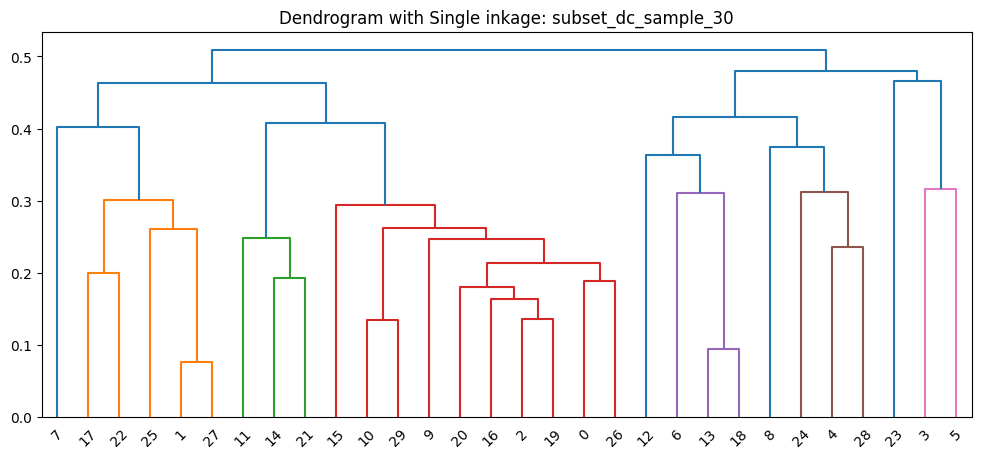

In [300]:
# for f in flist[:1]:
ts, z = cluster_and_plot(dc_file_dir+flist[3])
print(ts)

In [301]:
def find_cause(z, ts,the_true_cause, cur_i=None, cur_cluster=None):
    if(cur_i is None):
        cur_i=len(ts)-1
    if(cur_cluster is None):
        cur_cluster=set(list(range(int(z[-1][-1]))))
        print(cur_cluster)
    
    cluster_dict = drill_down(z, ts[cur_i])
    print(cluster_dict)
    found=False
    numer_of_retrains = 0
    for c in cluster_dict:
        if(cluster_dict[c].issubset(cur_cluster)):
            numer_of_retrains+=1
            if(the_true_cause.issubset(cluster_dict[c])):
                # this may not be true in practice 
                numer_of_retrains+=1
                if(cluster_dict[c]==the_true_cause):
                    print("found true cause via cluster!")
                    print(f"cur_cluster: {cur_cluster}")
                    return numer_of_retrains, True
                else:
                    sub_retrains, found = find_cause(z, ts, the_true_cause, cur_i-1, cluster_dict[c])
                    numer_of_retrains+=sub_retrains
    if(not found):
        print("not found enumerating now!")
        for i in range(len(cur_cluster)):
            print(i)
            total_cands = list(combinations(cur_cluster,i))
            for c in total_cands:
                numer_of_retrains+=1
                if(set(c)==the_true_cause):
                    print("found true casue via enumeration!")
                    print(f"cur_cluster: {cur_cluster}")
                    return numer_of_retrains, True
    else:
        return numer_of_retrains, True

In [302]:
def naive_find_cause(z, the_true_cause):
    numer_of_retrains = 0 
    rules=set(list(range(int(z[-1][-1]))))
    for i in range(len(rules)):
        total_cands = list(combinations(rules,i))
        for c in total_cands:
            numer_of_retrains +=1
            if(set(c)==the_true_cause):
                return numer_of_retrains    

In [303]:
import random

In [304]:
results = []
for t in range(1, 10):
    for i in range(0, 5):
        true_cause=set(random.sample(list(range(int(z[-1][-1]))), t))
        print(f"true_cause:{true_cause}")
        opt_retrains, _ = find_cause(z, ts, true_cause)
        naive_retrains = naive_find_cause(z, true_cause)
        print(f"casue, opt_retrains:{opt_retrains}, naive_retrains:{naive_retrains}")
        print('\n')
        results.append({"true_cause":true_cause, "true_cause_size":len(true_cause), 
                        "opt_retrains":opt_retrains, 'naive_retrains':naive_retrains})

true_cause:{22}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
defaultdict(<class 'set'>, {1: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}})
defaultdict(<class 'set'>, {1: {0, 1, 2, 7, 9, 10, 11, 14, 15, 16, 17, 19, 20, 21, 22, 25, 26, 27, 29}, 2: {3, 4, 5, 6, 8, 12, 13, 18, 23, 24, 28}})
defaultdict(<class 'set'>, {1: {0, 1, 2, 7, 9, 10, 11, 14, 15, 16, 17, 19, 20, 21, 22, 25, 26, 27, 29}, 3: {3, 5, 23}, 2: {4, 6, 8, 12, 13, 18, 24, 28}})
defaultdict(<class 'set'>, {1: {0, 1, 2, 7, 9, 10, 11, 14, 15, 16, 17, 19, 20, 21, 22, 25, 26, 27, 29}, 3: {3, 5}, 2: {4, 6, 8, 12, 13, 18, 24, 28}, 4: {23}})
defaultdict(<class 'set'>, {2: {0, 2, 9, 10, 11, 14, 15, 16, 19, 20, 21, 26, 29}, 1: {1, 7, 17, 22, 25, 27}, 4: {3, 5}, 3: {4, 6, 8, 12, 13, 18, 24, 28}, 5: {23}})
defaultdict(<class 'set'>, {2: {0, 2, 9, 10, 11, 14, 15, 16, 19, 20, 21, 26, 29}, 1: {1, 7, 17, 22, 25,

found true casue via enumeration!
cur_cluster: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
casue, opt_retrains:143886, naive_retrains:143882


true_cause:{2, 13, 15, 16, 23}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
defaultdict(<class 'set'>, {1: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}})
defaultdict(<class 'set'>, {1: {0, 1, 2, 7, 9, 10, 11, 14, 15, 16, 17, 19, 20, 21, 22, 25, 26, 27, 29}, 2: {3, 4, 5, 6, 8, 12, 13, 18, 23, 24, 28}})
not found enumerating now!
0
1
2
3
4
5
found true casue via enumeration!
cur_cluster: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
casue, opt_retrains:91443, naive_retrains:91439


true_cause:{0, 12, 16, 21, 24}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21

7
found true casue via enumeration!
cur_cluster: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
casue, opt_retrains:2592273, naive_retrains:2592269


true_cause:{5, 14, 15, 19, 20, 22, 26}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
defaultdict(<class 'set'>, {1: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}})
defaultdict(<class 'set'>, {1: {0, 1, 2, 7, 9, 10, 11, 14, 15, 16, 17, 19, 20, 21, 22, 25, 26, 27, 29}, 2: {3, 4, 5, 6, 8, 12, 13, 18, 23, 24, 28}})
not found enumerating now!
0
1
2
3
4
5
6
7
found true casue via enumeration!
cur_cluster: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
casue, opt_retrains:2450587, naive_retrains:2450583


true_cause:{1, 8, 9, 11, 24, 28, 29}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 

7
8
9
found true casue via enumeration!
cur_cluster: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
casue, opt_retrains:19953024, naive_retrains:19953020




In [305]:
df = pd.DataFrame(results)

In [306]:
df

,true_cause,true_cause_size,opt_retrains,naive_retrains
0,{22},1,49,24
1,{26},1,56,28
2,{27},1,66,29
3,{5},1,26,7
4,{15},1,34,17
5,"{2, 28}",2,118,114
6,"{17, 5}",2,182,178
7,"{22, 14}",2,143,354
8,"{17, 29}",2,174,400
9,"{24, 10}",2,294,290


In [307]:
df_aggregate = df.groupby(['true_cause_size']).mean().reset_index()

/tmp/ipykernel_18950/3095785777.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_aggregate = df.groupby(['true_cause_size']).mean().reset_index()


In [308]:
df_aggregate

,true_cause_size,opt_retrains,naive_retrains
0,1,46.2,21.0
1,2,182.2,267.2
2,3,2810.2,2902.8
3,4,26258.6,26254.6
4,5,117068.0,117064.0
5,6,493884.6,493880.6
6,7,1944764.6,1944760.6
7,8,5063327.6,5063323.6
8,9,19201480.0,19201476.0


In [309]:
df_aggregate.index=df_aggregate.true_cause_size

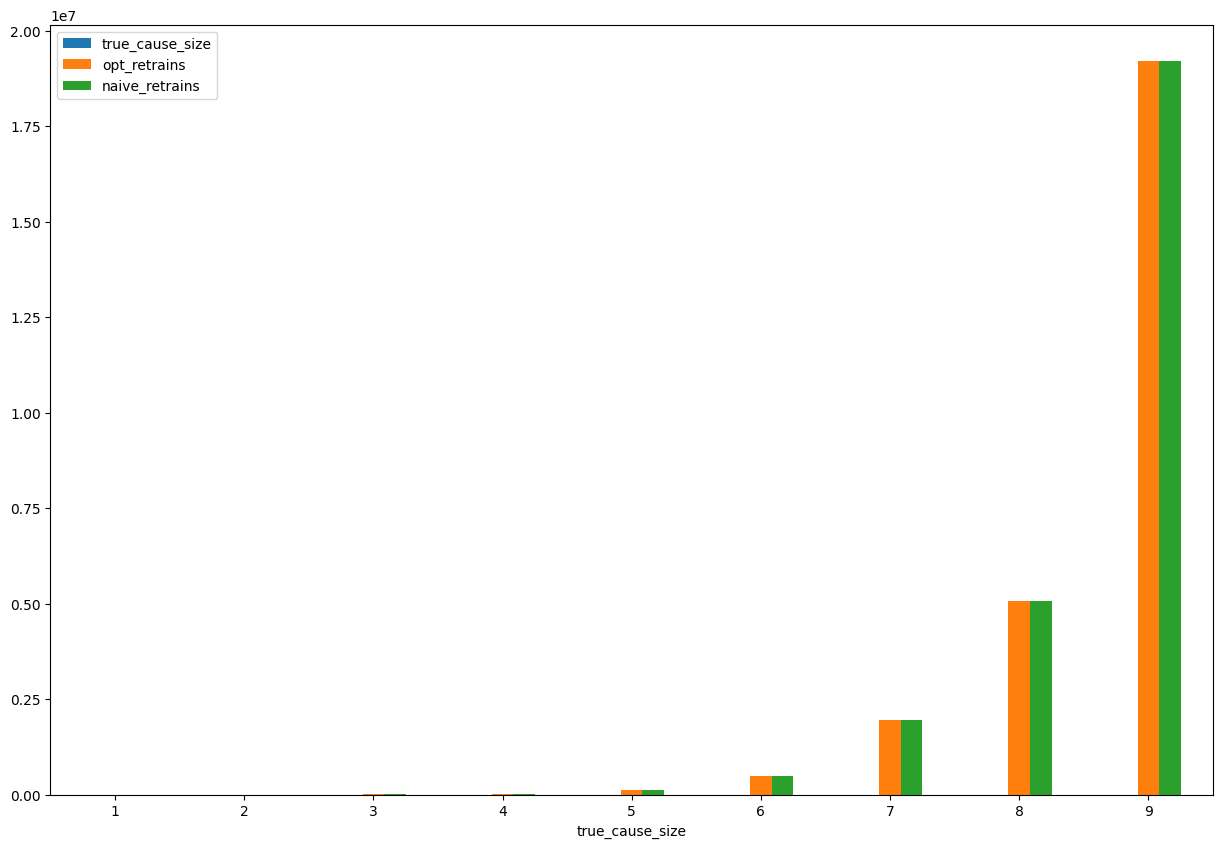

In [310]:
ax = df_aggregate.plot.bar(rot=0, figsize=(15, 10))